In [1]:
# https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from num2words import num2words
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import re
import seaborn as sns

import spacy
import en_core_web_sm


# Tfidf transformer 
from sklearn.feature_extraction.text import TfidfVectorizer

#https://www.nltk.org/howto/stem.html
from nltk.stem.porter import *


## Visualisation of the dataset

In [2]:
dataset = pd.read_csv('src/train.csv')
dataset.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
pourcentage_valeur_manquante = 100*dataset.isnull().sum()/dataset.shape[0]
print(pourcentage_valeur_manquante)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


## Drop unused columns

In [4]:
dataset = dataset.drop(columns=['id', 'location'])

## Re-write keyword column

In [5]:
dataset = dataset.dropna()
dataset['keyword'] = [ x.replace('%20', ' ') for x in dataset['keyword']]
len(dataset['keyword'].unique())

221

In [6]:
len(dataset)

7552

# Create function for drop Stopwords

In [7]:
# https://medium.com/@yashj302/stopwords-nlp-python-4aa57dc492af
nlp = en_core_web_sm.load()

stopwords = nlp.Defaults.stop_words
print(stopwords)

def cleanStopWorld(text):
    cleanedtext = []
    for item in nlp(text):
        if not item.is_stop:
            cleanedtext.append(item.text)
    return ' '.join(cleanedtext)
    

{'top', 'that', 'move', 'amongst', 'six', 'as', '‘re', 'too', 'nothing', 'cannot', 'how', 'whence', 'anyone', 'back', 'thereafter', 'on', 'so', 'eleven', 'front', 'amount', 'do', 'besides', 'wherein', 'everywhere', 'yourself', 'seeming', 'however', 'just', 'done', 'n’t', '’ve', 'there', 'becoming', 'afterwards', 'whereafter', 'due', 'fifty', 'call', 'last', 'forty', 'whenever', 'moreover', '‘ve', 'nobody', 'have', 'in', 'hence', "'m", 'were', 'by', 'ca', 'get', 'hereafter', 'he', "'ll", 'below', 'hundred', 'our', '’ll', 'elsewhere', 'yet', 'see', 'latterly', 'doing', 'beside', 'beyond', 'always', 'others', 'indeed', 'between', 'before', 'to', 'same', 'above', 'almost', 'those', 'then', 'anyhow', 'mostly', 'really', 'many', 'side', 'becomes', 'where', 'behind', 'hereby', 'therein', 'noone', 'own', 'whereby', 'when', 'one', 'themselves', 'perhaps', 'which', '‘s', 'some', 'become', 'made', 'thereby', 'during', 'put', 'here', 'her', 'ours', 'make', 'up', 'being', 'will', 'hers', 'was', 'na

## Create function for drop single character

In [8]:
def eraseSingleChar(words):
    new_text = ""
    for w in list(words.split(" ")):
        if len(w) > 1:
            new_text = new_text + " " + w
    return new_text

## Create function for stem words

In [9]:
# convert exemple "Player", "Playing" to "play"
stemmer = PorterStemmer()

def stemConverter(sentence):
    new_text = ""
    for w in list(sentence.split(" ")):
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

## Create function for convert numbers in full

In [10]:
# from numbers to string 
def convert_num_to_words(utterance):
      utterance = ' '.join([num2words.num2words(i) if i.isdigit() else i for i in utterance.split()])
      return utterance

## All in 1 process for convert sentences in keywords usable by TF-IDF

In [11]:
for column in ['keyword', 'text']:
    dataset[column] = [ np.char.lower(x) for x in dataset[column]]
    dataset[column] = [ str(x) for x in dataset[column] ] # str check for "numbers"
    dataset[column] = [ x.replace("\\/", "/").encode().decode('utf-8') for x in dataset[column] ] # magic line for error byte string
    dataset[column] = [ re.sub(r'http\S+', '', x) for x in dataset[column] ] # delete http 
    dataset[column] = [ re.sub('[^A-Za-z0-9 ]+', '', x) for x in dataset[column] ] # delete @#$€...
    #
    dataset[column] = [ cleanStopWorld(x) for x in dataset[column] ] # erase stop world 
    #
    dataset[column] = [ eraseSingleChar(x) for x in dataset[column] ] # erase isolate 2 chars
    #
    dataset[column] = [ stemConverter(x) for x in dataset[column] ] # convert to stem words

In [12]:
dataset = dataset.dropna()

In [13]:
dataset['text'] = dataset['keyword'].astype(str) + dataset['text'].astype(str)

In [14]:
dataset

,keyword,text,target
31,ablaz,ablaz bbcmtd wholesal market ablaz,1
32,ablaz,ablaz tri bring heavi metal rt,0
33,ablaz,ablaz africanbaz break newsnigeria flag set...,1
34,ablaz,ablaz cri set ablaz,0
35,ablaz,ablaz plu look sky night ablaz,0
...,...,...,...
7578,wreck,wreck jtruff23 cameronhack wreck,0
7579,wreck,wreck day work ve pretti wreck hahaha shout...,0
7580,wreck,wreck fx forex trade cramer iger word wreck...,0
7581,wreck,wreck enginesh great atmospher british lion...,0


## Create TF-IDF matrix 

In [15]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(dataset['text'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

##

# Create a tf-idf matrix for each token and each document
dataset_token = pd.DataFrame(dense, columns=[x for x in vectorizer.get_feature_names()] )

dataset_token

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0011,001116,0025,005225,010156,010217,0104,010401,0106,0111,...,zoom,zotar50,zouma,zourryart,zrnf,zss,zumiez,zurich,zxatheti,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

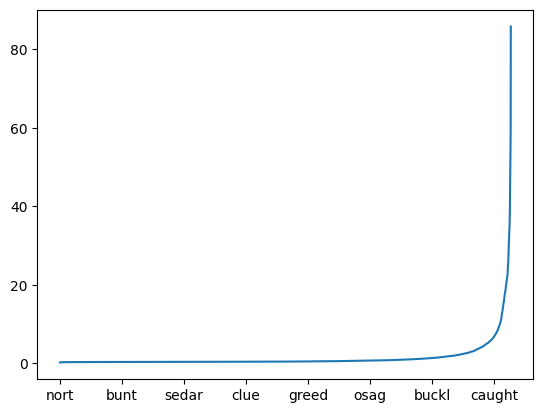

In [16]:
dataset_token.sum(axis=0).sort_values().plot()

## Build of dataset tokenized

In [17]:
#dataset = dataset.drop(columns=['text'])
print(f"keywords : {len(dataset['keyword'].unique())} / {len(dataset)}")
dataset = dataset.rename(columns={"keyword": "keyword_database", "target": "target_database"})
dataset = dataset.drop(columns=['text'])
display(dataset.head())

keywords : 166 / 7552


,keyword_database,target_database
31,ablaz,1
32,ablaz,0
33,ablaz,1
34,ablaz,0
35,ablaz,0


In [18]:
dataset = dataset.reset_index().drop(columns='index')
dataset_token = dataset_token.reset_index().drop(columns='index')

dataset_with_token = pd.concat([dataset, dataset_token], axis=1)
dataset_with_token = dataset_with_token.dropna(subset=['keyword_database', 'target_database'])
dataset_with_token = dataset_with_token.drop(columns=['level_0'])

dataset_with_token 

,keyword_database,target_database,0011,001116,0025,005225,010156,010217,0104,010401,...,zoom,zotar50,zouma,zourryart,zrnf,zss,zumiez,zurich,zxatheti,zzzz
0,ablaz,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ablaz,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ablaz,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ablaz,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ablaz,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7547,wreck,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7548,wreck,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7549,wreck,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7550,wreck,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
dataset_with_token.to_csv(r'src/dataset_tokenized.csv', index=False)